In [1]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
from LIFlayer import NHiddenModel
from randman_data import get_data_loaders
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import json
import tqdm.notebook as tqdm
from w import get_Ws
from init_utils import torch_init_LSUV


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')


device: cuda


In [3]:
def train(dataloader_train,dataloader_test,model,decay,lr=1e-3,epochs=20,device=device, use_W=False,W=None):

    ce_loss = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    train_hist = []
    test_hist = []
    loss_hist = []
    pbar_epochs = tqdm.trange(epochs,leave=False,unit='epoch',position=0)

    if use_W:
        model.init_mod_weights(W)



    for e in pbar_epochs:
        losses = []
        acc_test = []
        acc_train = []


        #test loop
        for x,label in dataloader_test:
            Sprobe = torch.zeros((dataloader_test.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_test.batch_size).to(device)
            model.init_states()
            with torch.no_grad():
                for t in range(x.shape[1]):
            

                    out_state = model(x[:,t])

                    Sprobe = decay * Sprobe + out_state.S
                prediction = Sprobe
                acc_test.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).cpu().numpy()))

        #train loop
        for x,label in dataloader_train:
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_train.batch_size).to(device)
            model.init_states()
            for t in range(x.shape[1]):
            

                #out_state,spikes_per_layer = model(x[:,t])
                out_state = model(x[:,t])
                

                Sprobe = decay * Sprobe + out_state.S
#               spikes_per_layer = spikes_per_layer + spikes_per_layer
#                print(spikes_per_layer)
                
            prediction = Sprobe

            with torch.no_grad():
                acc_train.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).numpy()))
            loss = ce_loss(prediction,label)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            opt.step()
            opt.zero_grad()

            if use_W:
                model.init_mod_weights(W)
        #print(torch.sum(prediction,axis=1))
        pbar_epochs.set_description(" Loss {0:1.4} | Test Acc {1:2.2%}: | Train Acc {2:2.2%} " .format(np.mean(losses),np.mean(acc_test),np.mean(acc_train)))
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(acc_train))
        test_hist.append(np.mean(acc_test))
    return loss_hist,train_hist,test_hist

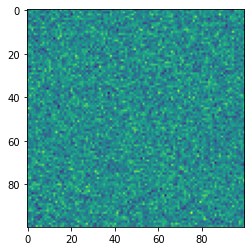

In [37]:
model = NHiddenModel(num_hidden_layers=1,in_channels=100,hidden_channels=100,out_channels=10,with_recurrent=False).to(device)
plt.imshow(model.layers[1].fc_layer.weight.data.cpu())

In [9]:

import datetime
import pickle


def run_experiment(variable,options,reps=reps, nb_classes=nb_classes,nb_units=nb_units,nb_steps=nb_steps,nb_samples=nb_samples,batchsize=batchsize,num_hidden_layers=num_hidden_layers,with_recurrent=with_recurrent,decay=decay,epochs=epochs,use_W=use_W,W=0,nb_blocks=nb_classes,epsilon=epsilon,modularity=modularity,lr=lr,print_weights=False,nametest=''):
    
    #init variable
   
    
    

    
    if variable != 'modularity':
        if use_W:
            W,W2=get_Ws(nb_units,nb_blocks,epsilon,modularity)

    metadata = locals()

    print(f'testing var -{variable}- with values -{options}-')
    dataloader_train,data_loader_test = get_data_loaders(nb_classes,nb_units,nb_steps,nb_samples,batchsize)
    experiment_data = {}
    
    for rep in range(reps):
        for i in range(len(options)):
        

        
            if variable == 'modularity':
                if use_W:
                    modularity = options[i]
                    W,W2=get_Ws(nb_units,nb_blocks,epsilon,modularity)

            if variable == 'num_hidden_layers':
                num_hidden_layers = options[i]

            if variable == 'lr':
                lr = options[i]
            
            
            model = NHiddenModel(num_hidden_layers=num_hidden_layers,in_channels=nb_units,hidden_channels=nb_units,out_channels=nb_classes,with_recurrent=with_recurrent).to(device)
            exploss,exptrain,exptest = train(dataloader_train,data_loader_test,model=model,decay=decay,epochs=epochs,use_W=use_W,W=W,lr=lr)

            experiment_data['loss_{}={}_rep{}'.format(variable,options[i],rep)] = exploss
            experiment_data['train_{}={}_rep{}'.format(variable,options[i],rep)] = exptrain
            experiment_data['test_{}={}_rep{}'.format(variable,options[i],rep)] = exptest
            
            #json_dict = json.dumps(experiment_data,indent=4)
            #meta_dict = json.dumps(metadata,indent=4)

            with open("experimental_data/{}{}.pkl".format(variable,nametest), 'wb') as f:
                pickle.dump(experiment_data, f)
            with open("experimental_data/{}{}_meta.pkl".format(variable,nametest), 'wb') as f:
                pickle.dump(metadata, f)
            #with open("\experimental_data\{}.json".format(variable),"w") as file:
            #    file.write(json_dict)
            #with open("\experimental_data\{}_meta.json".format(variable),"w") as file:
            #    file.write(meta_dict)

        if print_weights:
            plt.imshow(model.layers[1].fc_layer.weight.data.cpu())
            plt.colorbar()

    return experiment_data


    

testing var -modularity- with values -[0.0, 0.25, 0.5, 0.75, 1.0]-
device: cuda


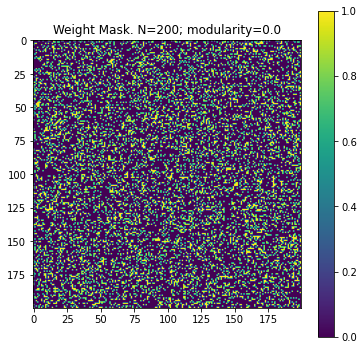

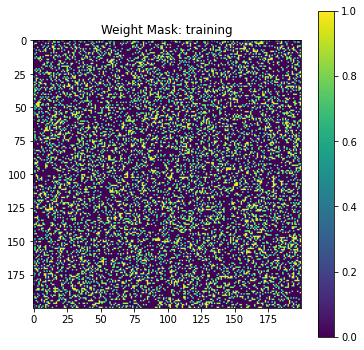

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


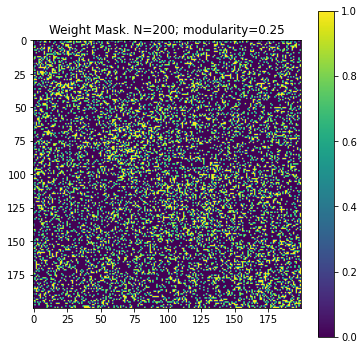

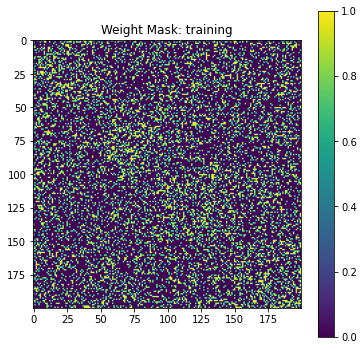

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


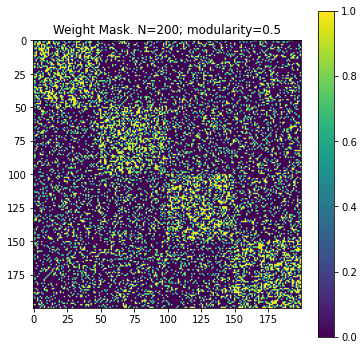

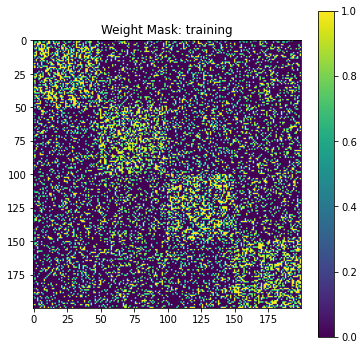

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


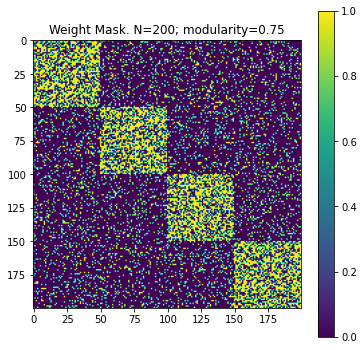

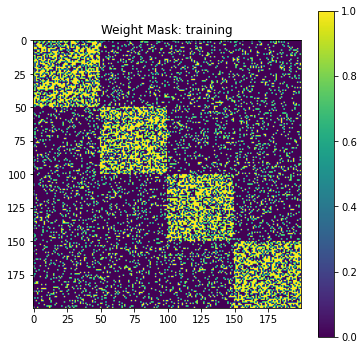

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


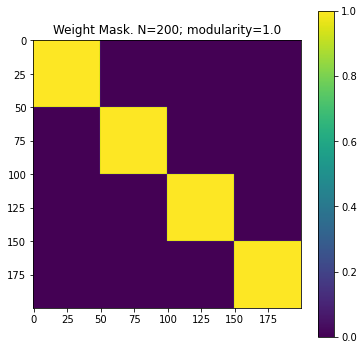

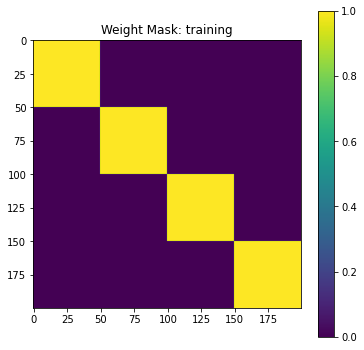

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


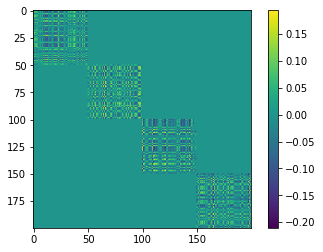

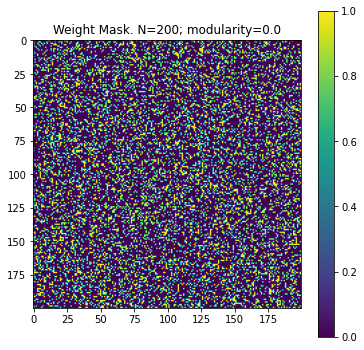

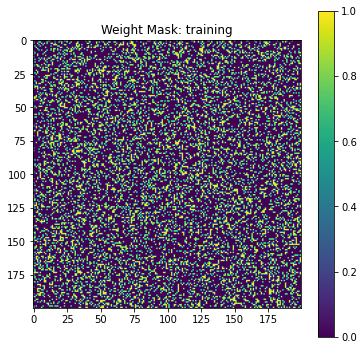

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


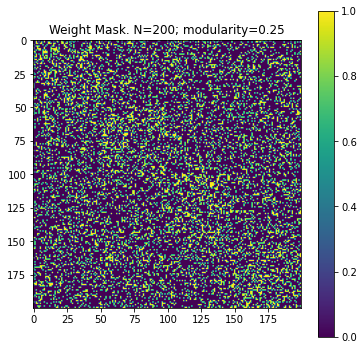

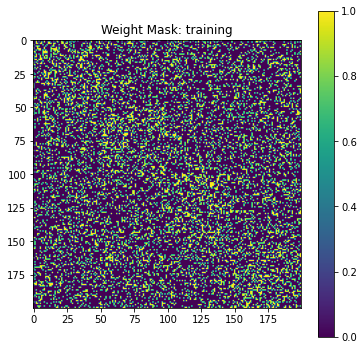

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


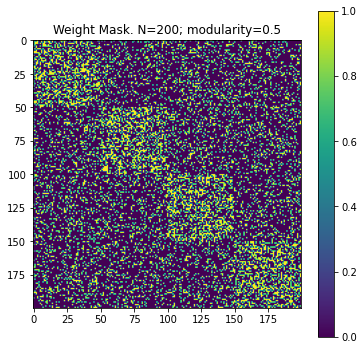

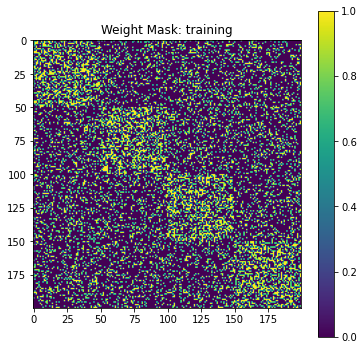

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


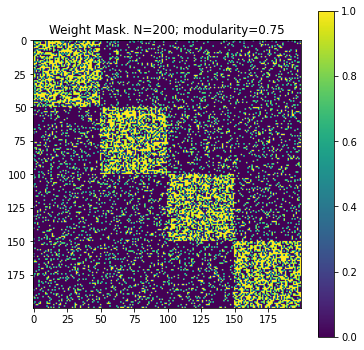

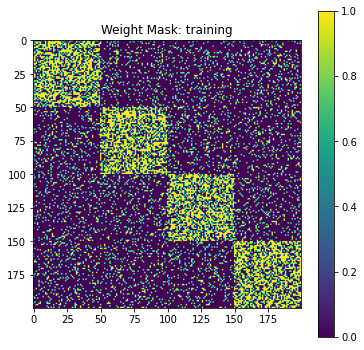

  0%|          | 0/30 [00:00<?, ?epoch/s]

device: cuda


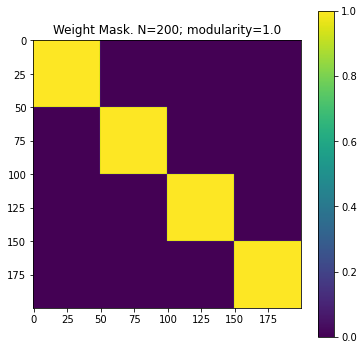

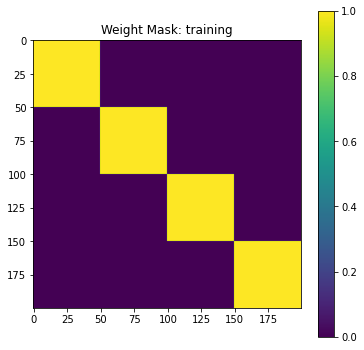

  0%|          | 0/30 [00:00<?, ?epoch/s]

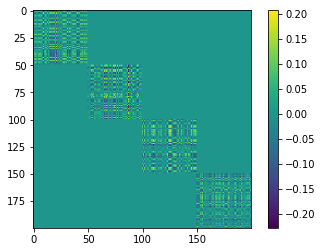

In [10]:
variable = 'modularity'
options = [0.,.25,.5,.75,1.]
reps=2
nb_classes=4
nb_units = 200
nb_steps = 100
nb_samples = 400
batchsize = 100
num_hidden_layers = 8
with_recurrent=False
decay=.99
epochs=30
use_W=True
W=0
nb_blocks=nb_classes
epsilon=1
modularity=0
lr=1e-3
print_weights = True

exp = run_experiment(variable=variable,options=options,reps=reps, nb_classes=nb_classes,nb_units=nb_units,nb_steps=nb_steps,nb_samples=nb_samples,batchsize=batchsize,num_hidden_layers=num_hidden_layers,with_recurrent=with_recurrent,decay=decay,epochs=epochs,use_W=use_W,W=0,nb_blocks=nb_classes,epsilon=epsilon,modularity=modularity,lr=lr,print_weights=print_weights,nametest='8lay30e2')

In [5]:
import pickle
with open('experimental_data/modularity8lay30e.pkl','rb') as f:
    mod_dict = pickle.load(f)

with open('experimental_data/modularity10laylong_meta.pkl','rb') as f:
    modmeta_dict = pickle.load(f)

In [5]:
mod_dict

{'loss_modularity=0.0_rep0': [1.726529,
  1.4829179,
  1.4807048,
  1.4882053,
  1.4804224,
  1.4452281,
  1.2834455,
  0.55554336,
  0.34591615,
  0.32382226,
  0.1668461,
  0.054918554,
  0.021119794,
  0.015431297,
  0.008694279,
  0.010218186,
  0.007560585,
  0.003316534,
  0.0034814954,
  0.0027887842,
  0.0028633715,
  0.0015253475,
  0.0011663147,
  0.00092657516,
  0.0011441995,
  0.0014524902,
  0.0009301759,
  0.00087204104,
  0.0009952508,
  0.0012148601],
 'train_modularity=0.0_rep0': [0.25666666666666665,
  0.24500000000000002,
  0.2575,
  0.24333333333333332,
  0.23416666666666663,
  0.2775,
  0.2991666666666667,
  0.7474999999999999,
  0.8141666666666666,
  0.8649999999999999,
  0.9366666666666666,
  0.9758333333333332,
  0.9933333333333333,
  0.9958333333333335,
  0.9983333333333334,
  0.9975,
  0.9975,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'test_modularity=0.0_rep0': [0.22333333333333336,
  0.25333333333333335,
  

In [24]:
with open('experimental_data/modularity1lay15e.pkl','rb') as f:
    dict1 = pickle.load(f)

with open('experimental_data/modularity2lay30e.pkl','rb') as f:
    dict2 = pickle.load(f)
with open('experimental_data/modularity3lay30e.pkl','rb') as f:
    dict3 = pickle.load(f)
with open('experimental_data/modularity4lay30e.pkl','rb') as f:
    dict4 = pickle.load(f)
with open('experimental_data/modularity5lay30e.pkl','rb') as f:
    dict5 = pickle.load(f)
with open('experimental_data/modularity6lay30e.pkl','rb') as f:
    dict6 = pickle.load(f)
with open('experimental_data/modularity7lay30e.pkl','rb') as f:
    dict7 = pickle.load(f)
with open('experimental_data/modularity8lay30e.pkl','rb') as f:
    dict8 = pickle.load(f)


In [7]:
df1 = pd.DataFrame(dict1)
df2 = pd.DataFrame(dict2)
df3 = pd.DataFrame(dict3)
df4 = pd.DataFrame(dict4)
df5 = pd.DataFrame(dict5)
df6 = pd.DataFrame(dict6)
df7 = pd.DataFrame(dict7)
df8 = pd.DataFrame(dict8)


,loss_modularity=0.0_rep0,train_modularity=0.0_rep0,test_modularity=0.0_rep0,loss_modularity=0.25_rep0,train_modularity=0.25_rep0,test_modularity=0.25_rep0,loss_modularity=0.5_rep0,train_modularity=0.5_rep0,test_modularity=0.5_rep0,loss_modularity=0.75_rep0,...,test_modularity=0.5_rep2,loss_modularity=0.75_rep2,train_modularity=0.75_rep2,test_modularity=0.75_rep2,loss_modularity=1.0_rep2,train_modularity=1.0_rep2,test_modularity=1.0_rep2,loss_modularity=0.0_rep3,train_modularity=0.0_rep3,test_modularity=0.0_rep3
0,1.811808,0.251667,0.263333,1.875149,0.261667,0.220000,1.811294,0.265833,0.240000,1.890516,...,0.260000,1.717133,0.260000,0.236667,1.897105,0.251667,0.266667,1.722487,0.251667,0.266667
1,1.457649,0.259167,0.276667,1.595765,0.234167,0.283333,1.536097,0.245000,0.226667,1.502391,...,0.223333,1.532696,0.235833,0.260000,1.675163,0.235000,0.253333,1.515466,0.242500,0.283333
2,1.476298,0.264167,0.236667,1.458199,0.256667,0.240000,1.442991,0.245833,0.236667,1.500984,...,0.306667,1.459440,0.249167,0.270000,1.539971,0.221667,0.236667,1.469891,0.239167,0.283333
3,1.441757,0.255000,0.233333,1.430269,0.275000,0.246667,1.463845,0.233333,0.240000,1.474375,...,0.233333,1.481797,0.240000,0.263333,1.465578,0.250000,0.230000,1.457096,0.244167,0.283333
4,1.447755,0.237500,0.260000,1.414716,0.249167,0.240000,1.477796,0.238333,0.243333,1.422933,...,0.236667,1.464102,0.235000,0.260000,1.436619,0.255833,0.253333,1.473243,0.230833,0.246667
5,1.421338,0.264167,0.260000,1.417619,0.237500,0.246667,1.473602,0.223333,0.243333,1.442340,...,0.223333,1.476215,0.252500,0.243333,1.447644,0.261667,0.296667,1.426590,0.240833,0.260000
6,1.470430,0.210833,0.250000,1.420486,0.234167,0.280000,1.459656,0.233333,0.263333,1.448399,...,0.263333,1.464399,0.250833,0.230000,1.447416,0.230000,0.246667,1.425447,0.262500,0.260000
7,1.456874,0.253333,0.250000,1.448127,0.251667,0.270000,1.432272,0.254167,0.286667,1.423002,...,0.260000,1.439818,0.262500,0.253333,1.492584,0.242500,0.270000,1.421568,0.244167,0.273333
8,1.450940,0.253333,0.256667,1.434657,0.269167,0.216667,1.438081,0.227500,0.123333,1.441803,...,0.280000,1.447763,0.245833,0.250000,1.455915,0.230833,0.216667,1.516424,0.210000,0.300000
9,1.387861,0.279167,0.220000,1.428919,0.260833,0.226667,1.441601,0.257500,0.240000,1.430456,...,0.240000,1.444811,0.253333,0.210000,1.465389,0.241667,0.233333,1.456969,0.250000,0.250000


In [6]:
import pandas as pd
df1 = pd.DataFrame(mod_dict)
#df2 = pd.DataFrame(dict2)
#df3 = pd.DataFrame(dict3)
#df[[col for col in list(mod_dict.keys()) if 'test' in col and '=10' in col]].plot(legend=True)

#plt.plot(df[[col for col in list(mod_dict.keys()) if 'test' in col and 'rep0' in col]])

In [37]:
df3 = df3.rename(columns=lambda x: x + "_2")

In [41]:
df1[df2.columns] = df2

In [43]:
df1[df3.columns] = df3

In [48]:
df1

,loss_modularity=0.25_rep0,train_modularity=0.25_rep0,test_modularity=0.25_rep0,loss_modularity=0.5_rep0,train_modularity=0.5_rep0,test_modularity=0.5_rep0,loss_modularity=0.75_rep0,train_modularity=0.75_rep0,test_modularity=0.75_rep0,loss_modularity=0.25_rep1,...,test_modularity=0.0_rep3_2,loss_modularity=1.0_rep3_2,train_modularity=1.0_rep3_2,test_modularity=1.0_rep3_2,loss_modularity=0.0_rep4_2,train_modularity=0.0_rep4_2,test_modularity=0.0_rep4_2,loss_modularity=1.0_rep4_2,train_modularity=1.0_rep4_2,test_modularity=1.0_rep4_2
0,1.932237,0.237500,0.270000,2.024096,0.248333,0.210000,1.778798,0.255000,0.250000,1.873649,...,0.226667,1.794534,0.260833,0.220000,1.674190,0.258333,0.223333,1.822795,0.249167,0.233333
1,1.527535,0.241667,0.246667,1.482651,0.254167,0.260000,1.463313,0.249167,0.283333,1.525951,...,0.233333,1.568496,0.255000,0.213333,1.438990,0.247500,0.273333,1.517119,0.246667,0.260000
2,1.503025,0.249167,0.226667,1.457993,0.241667,0.236667,1.428887,0.279167,0.253333,1.439165,...,0.313333,1.440666,0.272500,0.286667,1.457636,0.234167,0.320000,1.459848,0.262500,0.223333
3,1.487177,0.249167,0.256667,1.469032,0.258333,0.263333,1.488528,0.247500,0.253333,1.434830,...,0.253333,1.447254,0.269167,0.240000,1.489599,0.225833,0.233333,1.452567,0.247500,0.283333
4,1.419535,0.247500,0.250000,1.482989,0.251667,0.276667,1.467129,0.252500,0.280000,1.426456,...,0.240000,1.443001,0.232500,0.286667,1.491204,0.228333,0.230000,1.440258,0.257500,0.246667
5,1.443022,0.260833,0.253333,1.446628,0.230000,0.216667,1.446169,0.242500,0.216667,1.416180,...,0.216667,1.447920,0.251667,0.236667,1.464894,0.204167,0.276667,1.468869,0.250833,0.273333
6,1.449650,0.244167,0.240000,1.503024,0.217500,0.230000,1.440416,0.264167,0.280000,1.445234,...,0.213333,1.445933,0.251667,0.280000,1.495530,0.255833,0.236667,1.453234,0.249167,0.290000
7,1.443685,0.229167,0.203333,1.483261,0.275000,0.306667,1.461043,0.242500,0.243333,1.477119,...,0.203333,1.438755,0.244167,0.220000,1.455094,0.242500,0.220000,1.426954,0.291667,0.213333
8,1.431626,0.245833,0.236667,1.447326,0.242500,0.263333,1.283182,0.355000,0.320000,1.461003,...,0.246667,1.448888,0.260000,0.203333,1.370103,0.301667,0.246667,1.137925,0.447500,0.346667
9,1.307939,0.342500,0.216667,1.349734,0.305000,0.243333,0.855500,0.490000,0.466667,1.388451,...,0.273333,1.444724,0.255833,0.186667,1.076303,0.470833,0.383333,0.961236,0.565833,0.493333


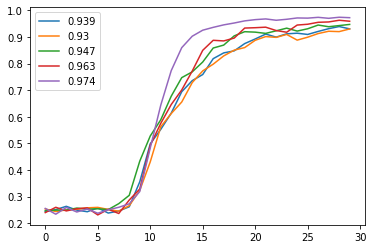

In [77]:
metric = 'test'
values = ['0.0','0.25','0.5','0.75','1.0']

def plot_stuff(metric,values):
    for value in values:
        mean_df = df1[[col for col in list(df1.keys()) if metric in col and value in col]].mean(axis=1)
        min_df = df1[[col for col in list(df1.keys()) if metric in col and value in col]].min(axis=1)
        max_df = df1[[col for col in list(df1.keys()) if metric in col and value in col]].max(axis=1) 
        plt.plot(mean_df,label=round(mean_df.max(),3))
        #plt.fill_between(df1.index,min_df,max_df,alpha=.2)
    plt.legend()
    plt.show()

plot_stuff(metric,values)

In [35]:
df[[col for col in list(mod_dict.keys()) if 'test' in col and '=1_' in col]].iloc[19].mean()

0.9688888888888889

In [132]:
df[[col for col in list(mod_dict.keys()) if 'test' in col and 'layers=8_' in col]].iloc[19]

test_num_hidden_layers=8_rep0    0.713333
test_num_hidden_layers=8_rep1    0.926667
test_num_hidden_layers=8_rep2    0.893333
test_num_hidden_layers=8_rep3    0.853333
test_num_hidden_layers=8_rep4    0.763333
test_num_hidden_layers=8_rep5    0.893333
test_num_hidden_layers=8_rep6    0.766667
test_num_hidden_layers=8_rep7    0.796667
test_num_hidden_layers=8_rep8    0.776667
test_num_hidden_layers=8_rep9    0.903333
Name: 19, dtype: float64

In [78]:
with open("experimental_data/mod7_e30_10reps_all.pkl", 'wb') as f:
                pickle.dump(df1, f)

In [16]:
round(tic,)

1658137259

In [14]:
exp_data = run_experiment('num_hidden_layers',[0,1,2],epochs=5)

testing var -num_hidden_layers- with values -[0, 1, 2]-


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/5 [00:00<?, ?epoch/s]

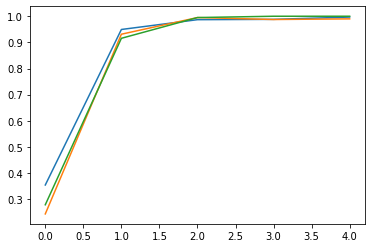

In [17]:
plt.plot(exp_data['train_num_hidden_layers=0'])
plt.plot(exp_data['train_num_hidden_layers=1'])
plt.plot(exp_data['train_num_hidden_layers=2'])

In [9]:
def check(a,b,c):
    args = locals()
    print(args)
    return args

args = check(3,'le',[3,4,5,6])

{'a': 3, 'b': 'le', 'c': [3, 4, 5, 6]}
